In [ ]:
! git clone https://github.com/westedcrean/master-thesis && pip install wandb loguru

In [9]:
! cd master-thesis && git pull

remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 7 (delta 5), reused 7 (delta 5), pack-reused 0
Unpacking objects: 100% (7/7), done.
From https://github.com/westedcrean/master-thesis
   c1445e1..a26e3ee  main       -> origin/main
Updating c1445e1..a26e3ee
Fast-forward
 notebooks/test_vgg.ipynb      | 27 ++++++++++++++
 src/training/create_models.py | 85 +++++++++++++++++++++++++++++++++++++++++++
 2 files changed, 112 insertions(+)


In [10]:
! cp -r master-thesis/* .

In [3]:
! cd src && ./download_dataset.sh && python create_datasets.py

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Extracting  znaki/png/9/9_1358_98_M_2B.png                                99%  OK 
Extracting  znaki/png/9/9_1359_97_M_2F.png                                99%  OK 
Extracting  znaki/png/9/9_1359_98_M_2B.png                                99%  OK 
Extracting  znaki/png/9/9_1360_97_M_2F.png                                99%  OK 
Extracting  znaki/png/9/9_1360_98_M_2B.png                                99%  OK 
Extracting  znaki/png/9/9_1361_96_M_2B.png                                99%  OK 
Extracting  znaki/png/9/9_1361_97_M_2F.png                                99%  OK 
Extracting  znaki/png/9/9_1362_98_M_2D.png                                99%  OK 
Extracting  znaki/png/9/9_1362_98_M_2F.png                                99%  OK 
Extracting  znaki/png/9/9_1363_98_M_2F.png                                99%  OK 
Extracting  zna

In [3]:
from pathlib import Path

import wandb
from wandb.keras import WandbCallback

import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sys

sys.path.append(str((Path.cwd().absolute() / "src").resolve()))

In [4]:
from training.engine import train, test
from training.create_models import get_models_for_experiment
from datasets import numbers, get_class_name, log_dataset_statistics
from datasets import (
    numbers,
    get_class_name,
    log_dataset_statistics,
)
from visualisations.history import plot_history
from visualisations.classification_metrics import get_classification_report

In [5]:
train_data = numbers(path="data/numbers/train", subset="training")
validation_data = numbers(path="data/numbers/train", subset="validation")
test_data = numbers(path="data/numbers/test", subset=None, validation_split=None)

class_labels = [get_class_name(cn) for cn in validation_data.class_names]

model = None

num_classes=10
input_shape=(32, 32, 3)

Found 55478 files belonging to 10 classes.
Using 44383 files for training.
Found 55478 files belonging to 10 classes.
Using 11095 files for validation.
Found 6169 files belonging to 10 classes.


In [6]:
from typing import List, Tuple
import tensorflow as tf

def get_vgg_model(
    input_shape: tuple,
    num_classes: int,
    learning_rate: float,
    model_name: str,
    optimizer: tf.keras.optimizers.Optimizer = tf.keras.optimizers.Adam,
    loss: tf.keras.losses.Loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics: list = [tf.keras.metrics.CategoricalAccuracy()],
) -> Tuple[tf.keras.Model, dict]:
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs

    # Convolutional layers
    x = tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.Conv2D(
        filters=64, kernel_size=(3, 3), padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3, 3), padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.Conv2D(
        filters=128, kernel_size=(3, 3), padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.Conv2D(
        filters=256, kernel_size=(3, 3), padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(
        filters=512, kernel_size=(3, 3), padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.Conv2D(
        filters=512, kernel_size=(3, 3), padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.Conv2D(
        filters=512, kernel_size=(3, 3), padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = tf.keras.layers.Conv2D(
        filters=512, kernel_size=(3, 3), padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.Conv2D(
        filters=512, kernel_size=(3, 3), padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.Conv2D(
        filters=512, kernel_size=(3, 3), padding="same", activation="relu"
    )(x)
    x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    # Flatten
    x = tf.keras.layers.Flatten()(x)

    # Dense layers
    x = tf.keras.layers.Dense(units=4096, activation="relu")(x)
    x = tf.keras.layers.Dense(units=4096, activation="relu")(x)

    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    # Create model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    # Compile model
    model.compile(
        optimizer=optimizer(learning_rate=learning_rate),
        loss=loss,
        metrics=metrics,
    )

    config = dict(
        learning_rate=learning_rate,
        model_name=model_name,
    )

    return model, config

model, config = get_vgg_model(
    input_shape=input_shape,
    num_classes=num_classes,
    learning_rate=0.001,
    model_name=f"VGG1",
)

In [ ]:
wandb.init(project="cnn_experiment", config=config, name=config["model_name"])
history = train(
    train_data,
    model,
    epochs=50,
    validation_dataset=validation_data,
    callbacks=[
        WandbCallback(), 
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        ],
)

_, y_true, y_pred, y_probas = test(test_data, model)
wandb.sklearn.plot_confusion_matrix(y_true, y_pred)
wandb.sklearn.plot_roc(y_true, y_probas, class_labels)
cl = get_classification_report(y_true, y_pred, class_labels=class_labels)
wandb.log(
    {
        "classification_report": cl,
        "precision_history": wandb.plot.line(
            cl, "epoch", "precision", title="Precision History"
        ),
        "recall_history": wandb.plot.line(
            cl, "epoch", "recall", title="Recall History"
        ),
        "f1_score_history": wandb.plot.line(
            cl, "epoch", "f1-score", title="F1 Score History"
        ),
        "accuracy": plot_history(history),
    }
)
wandb.log(
    {
        "final_training_accuracy": history.history["accuracy"][-1],
        "final_validation_accuracy": history.history["val_accuracy"][-1],
    }
)
wandb.finish()

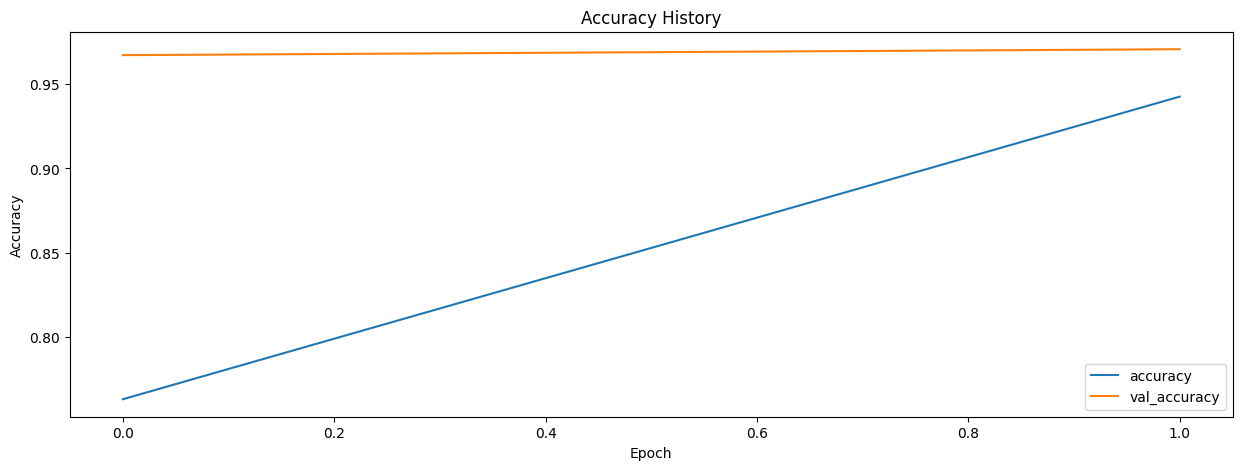

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

# plot categorical_accuracy history in matplotlib
ax.plot(history.history["categorical_accuracy"], label="accuracy")
ax.plot(history.history["val_categorical_accuracy"], label="val_accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(loc="lower right")
ax.set_title("Accuracy History")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import wandb


def get_classification_report(y_true, y_pred, class_labels, epoch=None):
    report = classification_report(
        y_true, y_pred, target_names=class_labels, output_dict=True
    )
    columns = ["epoch"] if epoch else []
    columns.extend(["precision", "recall", "f1-score", "support"])
    
    data = []
    for cl in class_labels:
        row = [epoch] if epoch else []
        row.extend([report[cl][k] for k in columns[1:]])
        data.append(row) 

    return wandb.Table(
        data=data,
        columns=["epoch", "class", "precision", "recall", "f1-score", "support"],
    )


get_classification_report(y_true, y_pred, class_labels=class_labels)

In [ ]:
import pandas as pd
data = []


df = pd.DataFrame(data, columns=["class", "precision", "recall", "f1-score", "support"])

df

,class,precision,recall,f1-score,support
0,0,0.993528,0.995138,0.994332,617
1,1,0.995074,0.980583,0.987775,618
2,2,0.988275,0.953150,0.970395,619
3,3,0.996473,0.917208,0.955199,616
4,4,0.985197,0.969256,0.977162,618
5,5,0.980551,0.982143,0.981346,616
6,6,0.983819,0.988618,0.986212,615
7,7,0.985342,0.982143,0.983740,616
8,8,0.934375,0.969206,0.951472,617
9,9,0.888399,0.980551,0.932203,617
